In [129]:
# Base imports
import os
import sqlite3
from collections import Counter
from string import punctuation

# Data manimpulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import shifterator as sh

# Model preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

# Model evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Transformers
from transformers import pipeline
from transformers import AutoTokenizer

In [2]:
############ FUNCTIONS ############
def find_params(X_train, y_train,
                clf,strip_accents=['unicode', None],min_df=[1,2,3,4,5],
                max_df=[0.3, 0.4, 0.5, 0.6, 0.7],
                ngram_range=[(1,1),(1,2),(1,3)],
                stop_words=[None, stopwords.words('english')],
                use_idf=(True, False),
                **kwargs):
    """Returns the optimal parameters from a grid search.
    
    Arguments
    X_train : X training data 
    y_train : y training data
    clf : a sklearn classifier
    stip_accents : TfidfVectorizer strip_accents parameter
    min_df : TfidfVectorizer min_df parameter
    max_df : TfidfVectorizer max_df parameter
    ngram_range : TfidfVectorizer ngram_range parameter
    stop_words : TfidfVectorizer stop_words parameter
    use_idf : TfidfVectorizer use_idf parameter
    **kwargs : optional model parameters
    """
    # Create Pipeline
    model_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', clf)
    ])

    # Create parameter space for TfidfVectorizer
    tfidf_params = {
            'tfidf__strip_accents': strip_accents,
            'tfidf__min_df': min_df,
            'tfidf__max_df': max_df,
            'tfidf__ngram_range': ngram_range,
            'tfidf__stop_words': stop_words,
            'tfidf__use_idf': use_idf,
    }

    # Create parameter space for classifier
    model_params = {}
    if kwargs:
        for k,v in kwargs.items():
            model_params['clf__'+k] = v

    # Create joined parameter space   
    pipeline_params = {**tfidf_params, **model_params}

    # Initialize grid search object
    gs_clf = GridSearchCV(model_pipeline, pipeline_params, scoring='f1_micro', 
                          cv=5, n_jobs=-1)

    # Fit grid search to training data
    gs_clf = gs_clf.fit(X_train, y_train)

    # Return results
    best_params = gs_clf.best_params_
    if best_params['tfidf__stop_words']:
        best_params['tfidf__stop_words'] = True
        
    return best_params


def build_model(X_train, y_train, X_test, y_test, clf, 
                strip_accents=None, stop_words=None, 
                ngram_range = (1,1), max_df=1, min_df=1, use_idf=True):
    """Build a model from training data. Returns a classification report and 
    confusion matrix based off of the testing data provided.
    
    Arguments
    X_train : X training data
    y_train : y training data
    X_test : X testing data
    y_test : y testing data
    clf : classification model
    strip_accents: TfidfVectorizer strip_accents parameter
    min_df : TfidfVectorizer min_df parameter
    max_df : TfidfVectorizer max_df parameter
    ngram_range : TfidfVectorizer ngram_range parameter
    stop_words : TfidfVectorizer stop_words parameter
    use_idf : TfidfVectorizer use_idf parameter
    """
    # Initialize vectorization parameters
    vectorizer = TfidfVectorizer(strip_accents=strip_accents,
                                 min_df=min_df,
                                 max_df=max_df,
                                 ngram_range=ngram_range,
                                 stop_words=stop_words,
                                 use_idf=use_idf)

    # Vectorize training and test data
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Train classifier
    clf.fit(X_train_tfidf, y_train)

    # Predict of test data
    y_pred = clf.predict(X_test_tfidf)

    # Get classification report
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()
    
    return clf;


def text_len(text):
    """Return the minimum and maximum length of a body of text
    for input in a tranformer model.
    """
    tokenized_text = tokenizer(text)
    text_length = len(tokenized_text['input_ids'])
    min_len = 1
    max_len = int(np.ceil(text_length * 0.3))
    
    return text_length, min_len, max_len


def get_test_vec(X_train, X_test, vectorizer):
    """Returns vectorized test data"""
    vectorizer.fit_transform(X_train)
    return vectorizer.transform(X_test)


def series2list(series):
    """Convert a series of lists into a single list"""
    full_list = []
    for row in series:
        full_list.extend(row)
    return full_list


def remove_punct(series):
    """Remove punctuation from a pandas Series"""
    punct_num = punctuation+'1234567890'
    return "".join([word for word in series if word not in punct_num])


def remove_stopwords(corpora_freq):
    """Remove stopwords from a list of word frequencies"""
    return [word for word in corpora_freq if word[0] not in stop_words]


def word_count_pipeline(series):
    """Given a pandas Series return list of frequency counts"""
    corpora = series.apply(str.lower)
    corpora = corpora.apply(remove_punct)
    corpora_tokenized = corpora.apply(word_tokenize)
    corpora_list = series2list(corpora_tokenized)
    return Counter(corpora_list).most_common()


def plot_word_counts(dem_count, rep_count):
    """Plot top 25 words in a corpus"""
    # Extract the word, frequency pairs
    dx, dy = zip(*dem_count[:25])
    rx, ry = zip(*rep_count[:25])

    # Plot most frequent words in bills proposed by democrats
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.title('Top 25 Words in Democratic Bills')
    plt.ylabel('Word')
    plt.xlabel('Frequency (Count)')
    plt.barh(dx[::-1], dy[::-1])

    # Plot most frequent words in bills proposed by republicans
    plt.subplot(1,2,2)
    plt.title('Top 25 Words in Republican Bills')
    plt.ylabel('Word')
    plt.xlabel('Frequency (Count)')
    plt.barh(rx[::-1], ry[::-1])

    plt.tight_layout()
    plt.show();

    
def convert_shifterator(word_frequencies):
    """Convert word frequencies to dictionary for shifterator plot"""
    key, value = zip(*word_frequencies)
    return {k:v for k,v in zip(key, value)}
############ END FUNCTIONS ############

In [3]:
# Change directory
os.chdir('final project/CS254/data/')

# Load data
conn = sqlite3.connect('congress.db')
congress = pd.read_sql_query("SELECT * FROM congress", conn)
conn.close()

# Transformers

We will be comparing the classification of the following algorithms:
1. Logistic Regression
2. Multinomial Naive Bayes
3. Support Vector Classification (SVC)
4. Linear Support Vector Machine
5. Random Forest

For each model we will compare the results of training the model on a summarized version of the text to the full bill text summary on the congress.gov website.

In [4]:
summarizer = pipeline("summarization")
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


In [181]:
hf_summarizer = []
n = 3000
for text in congress['bill_summary']:
    text_length, min_len, max_len = text_len(text)
    if text_length <= 1024:
        hf_summarizer.append(summarizer(text, min_length=min_len, max_length=max_len)[0]['summary_text'])
    
    # Text is too long, needs to be broken up to run
    else:
        summarized_text = []
        for i in range(int(np.ceil(len(text) / n))):
            partial_text = text[i*n:(i+1)*n]
            _,_,max_len = text_len(partial_text)
            summarized_text.append(summarizer(partial_text,
                                              min_length=min_len,
                                              max_length=max_len)[0]['summary_text'])
        hf_summarizer.append("".join(summarized_text))

In [186]:
congress['hf_summary'] = hf_summarizer

In [4]:
np.random.seed(1999)

# Extract just the sponsor party and bill summaries
df = pd.read_csv('hf_summary.csv')
df.fillna("", inplace=True)

# Remove the Libertarian and Independent parties
df = df[df['sponsor_party'] != 'L']
df = df[df['sponsor_party'] != 'I']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df[['bill_summary', 'hf_summary']],
                                                    df['sponsor_party'],
                                                    random_state=0,
                                                    test_size=0.2
                                                   )

## Multinomial Naive Bayes (HF)

In [43]:
find_params(X_train['hf_summary'], y_train, MultinomialNB(), max_df=[0.1, 0.005], min_df=[1,2], ngram_range=[(1,2), (1,3)], strip_accents=['unicode'], use_idf=[True])

{'tfidf__max_df': 0.005,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 3),
 'tfidf__stop_words': True,
 'tfidf__strip_accents': 'unicode',
 'tfidf__use_idf': True}

              precision    recall  f1-score   support

           D       0.69      0.90      0.78      2918
           R       0.80      0.49      0.61      2290

    accuracy                           0.72      5208
   macro avg       0.75      0.70      0.70      5208
weighted avg       0.74      0.72      0.71      5208



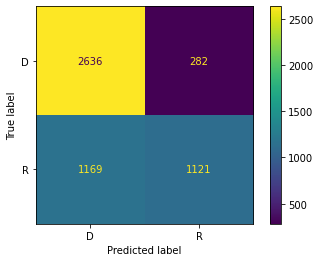

In [45]:
build_model(X_train['hf_summary'], y_train, X_test['hf_summary'], y_test,
                     MultinomialNB(),
                     max_df=0.005,
                     min_df=1,
                     ngram_range=(1,3),
                     stop_words=stopwords.words('english'),
                     strip_accents='unicode',
                     use_idf=True)

              precision    recall  f1-score   support

           D       0.74      0.93      0.83      2918
           R       0.87      0.58      0.70      2290

    accuracy                           0.78      5208
   macro avg       0.81      0.76      0.76      5208
weighted avg       0.80      0.78      0.77      5208



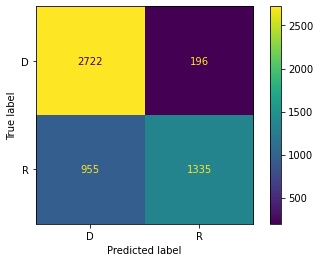

In [5]:
clf_nb = build_model(X_train['bill_summary'], y_train, X_test['bill_summary'], y_test,
                     MultinomialNB(),
                     max_df=0.005,
                     min_df=1,
                     ngram_range=(1,3),
                     stop_words=stopwords.words('english'),
                     strip_accents='unicode',
                     use_idf=True)

https://billmap.govtrack.us/bills/114hr3682

## Logistic Regression (HF)

In [34]:
find_params(X_train['hf_summary'], y_train, LogisticRegression(max_iter=150), max_df=[0.5, 0.51], min_df=[1], ngram_range=[(1,3)], use_idf=[True])

{'tfidf__max_df': 0.5,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 3),
 'tfidf__stop_words': True,
 'tfidf__strip_accents': None,
 'tfidf__use_idf': True}

              precision    recall  f1-score   support

           D       0.71      0.82      0.76      2918
           R       0.71      0.58      0.64      2290

    accuracy                           0.71      5208
   macro avg       0.71      0.70      0.70      5208
weighted avg       0.71      0.71      0.71      5208



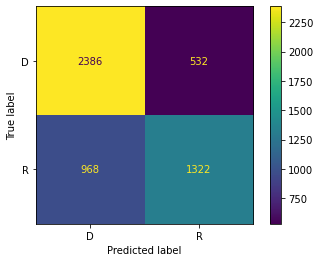

In [47]:
build_model(X_train['hf_summary'], y_train, X_test['hf_summary'], y_test,
                     LogisticRegression(max_iter=300),
                     max_df=0.5,
                     min_df=1,
                     ngram_range=(1,3),
                     stop_words=None,
                     strip_accents='unicode',
                     use_idf=True
                    )

              precision    recall  f1-score   support

           D       0.76      0.85      0.80      2918
           R       0.77      0.66      0.71      2290

    accuracy                           0.76      5208
   macro avg       0.77      0.75      0.76      5208
weighted avg       0.76      0.76      0.76      5208



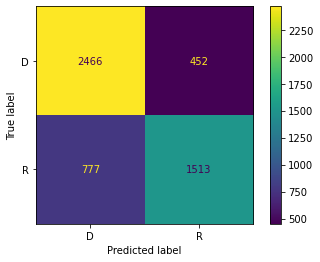

In [6]:
clf_lr = build_model(X_train['bill_summary'], y_train, X_test['bill_summary'], y_test,
                     LogisticRegression(max_iter=300),
                     max_df=0.5,
                     min_df=1,
                     ngram_range=(1,3),
                     stop_words=None,
                     strip_accents='unicode',
                     use_idf=True
                    )

## Support Vector Classification (SVC)

In [ ]:
find_params(X_train, y_train, SVC(), kernel=['poly', 'rbf', 'sigmoid'], gamma=['auto', 'scale'])

              precision    recall  f1-score   support

           D       0.72      0.82      0.77      2918
           R       0.73      0.60      0.66      2290

    accuracy                           0.72      5208
   macro avg       0.72      0.71      0.71      5208
weighted avg       0.72      0.72      0.72      5208



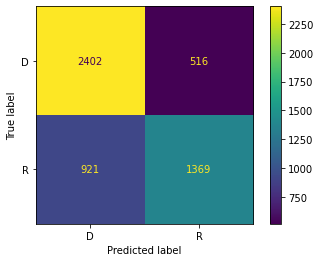

In [50]:
build_model(X_train['hf_summary'], y_train, X_test['hf_summary'], y_test,
                      SVC(kernel='rbf',
                          gamma='scale',
                          probability=True
                         ),
                      max_df=0.5,
                      min_df=5,
                      ngram_range=(1,3),
                      stop_words=stopwords.words('english'),
                      strip_accents='unicode',
                      use_idf=True
                     )

              precision    recall  f1-score   support

           D       0.79      0.86      0.83      2918
           R       0.80      0.71      0.75      2290

    accuracy                           0.80      5208
   macro avg       0.80      0.79      0.79      5208
weighted avg       0.80      0.80      0.79      5208



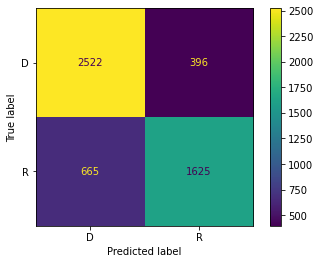

In [7]:
clf_svc = build_model(X_train['bill_summary'], y_train, X_test['bill_summary'], y_test,
                      SVC(kernel='rbf',
                          gamma='scale',
                          probability=True
                         ),
                      max_df=0.5,
                      min_df=5,
                      ngram_range=(1,3),
                      stop_words=stopwords.words('english'),
                      strip_accents='unicode',
                      use_idf=True
                     )

## SGD Classifier

In [65]:
find_params(X_train['hf_summary'], y_train, SGDClassifier(n_jobs=-1), 
            loss=['log', 'hinge'], 
            max_df=[0.65], 
            min_df=[1,2], 
            ngram_range=[(1,2),(1,3)], 
            strip_accents=['unicode'], 
            use_idf=(True,))

{'clf__loss': 'hinge',
 'tfidf__max_df': 0.65,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 3),
 'tfidf__stop_words': True,
 'tfidf__strip_accents': 'unicode',
 'tfidf__use_idf': True}

              precision    recall  f1-score   support

           D       0.71      0.84      0.77      2918
           R       0.73      0.55      0.63      2290

    accuracy                           0.71      5208
   macro avg       0.72      0.70      0.70      5208
weighted avg       0.72      0.71      0.71      5208



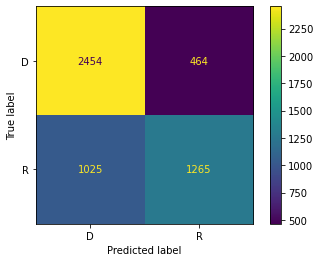

In [66]:
build_model(X_train['hf_summary'], y_train, X_test['hf_summary'], y_test,
                      SGDClassifier(n_jobs=-1, loss='hinge'),
                      max_df=0.65,
                      min_df=1,
                      ngram_range=(1,3),
                      stop_words=stopwords.words('english'),
                      strip_accents='unicode',
                      use_idf=True
                     )

In [68]:
find_params(X_train['bill_summary'], y_train, SGDClassifier(n_jobs=-1),
            loss=['log', 'hinge'], 
            max_df=[0.4, 0.35, 0.3], 
            min_df=[1,2], 
            ngram_range=[(1,2),(1,3)], 
            strip_accents=['unicode'], 
            use_idf=(True,))

{'clf__loss': 'hinge',
 'tfidf__max_df': 0.3,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 3),
 'tfidf__stop_words': None,
 'tfidf__strip_accents': 'unicode',
 'tfidf__use_idf': True}

              precision    recall  f1-score   support

           D       0.76      0.86      0.81      2918
           R       0.79      0.66      0.72      2290

    accuracy                           0.77      5208
   macro avg       0.78      0.76      0.76      5208
weighted avg       0.77      0.77      0.77      5208



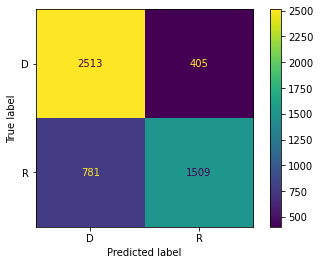

In [8]:
clf_sgd = build_model(X_train['bill_summary'], y_train, X_test['bill_summary'], y_test,
                      SGDClassifier(n_jobs=-1, loss='hinge'
                                   ),
                      max_df=0.3,
                      min_df=1,
                      ngram_range=(1,3),
                      stop_words=None,
                      strip_accents='unicode',
                      use_idf=True
                     )

## Random Forest

In [72]:
find_params(X_train['hf_summary'], y_train, RandomForestClassifier(),
            max_features=['auto'],
            max_depth=[None],
            max_df=[0.3, 0.2],
            min_df=[1,2], 
            ngram_range=[(1,1), (1,2)], 
            strip_accents=['unicode'], 
            use_idf=(True,)
           )

{'clf__max_depth': None,
 'clf__max_features': 'auto',
 'tfidf__max_df': 0.3,
 'tfidf__min_df': 2,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': True,
 'tfidf__strip_accents': 'unicode',
 'tfidf__use_idf': True}

              precision    recall  f1-score   support

           D       0.71      0.83      0.76      2918
           R       0.72      0.57      0.63      2290

    accuracy                           0.71      5208
   macro avg       0.71      0.70      0.70      5208
weighted avg       0.71      0.71      0.71      5208



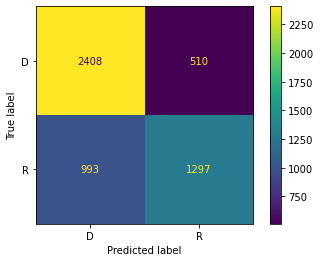

In [76]:
build_model(X_train['hf_summary'], y_train, X_test['hf_summary'], y_test,
                     RandomForestClassifier(),
                     max_df=0.3,
                     min_df=2,
                     ngram_range=(1,1),
                     stop_words=stopwords.words('english'),
                     strip_accents='unicode',
                     use_idf=True
                    )

In [78]:
find_params(X_train['bill_summary'], y_train, RandomForestClassifier(),
            max_depth=[None],
            max_df=[0.2, 0.1],
            min_df=[1,2,3], 
            ngram_range=[(1,1), (1,2)], 
            strip_accents=['unicode'], 
            use_idf=(True,)
           )

{'clf__max_depth': None,
 'tfidf__max_df': 0.1,
 'tfidf__min_df': 2,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': True,
 'tfidf__strip_accents': 'unicode',
 'tfidf__use_idf': True}

              precision    recall  f1-score   support

           D       0.77      0.86      0.82      2918
           R       0.79      0.68      0.73      2290

    accuracy                           0.78      5208
   macro avg       0.78      0.77      0.77      5208
weighted avg       0.78      0.78      0.78      5208



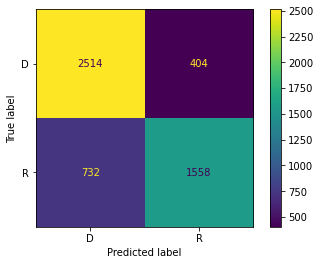

In [9]:
clf_rf = build_model(X_train['bill_summary'], y_train, X_test['bill_summary'], y_test,
                     RandomForestClassifier(),
                     max_df=0.1,
                     min_df=2,
                     ngram_range=(1,2),
                     stop_words=stopwords.words('english'),
                     strip_accents='unicode',
                     use_idf=True
                    )

In [193]:
from sklearn.ensemble import VotingClassifier

              precision    recall  f1-score   support

           D       0.77      0.89      0.82      2918
           R       0.83      0.65      0.73      2290

    accuracy                           0.79      5208
   macro avg       0.80      0.77      0.78      5208
weighted avg       0.79      0.79      0.78      5208



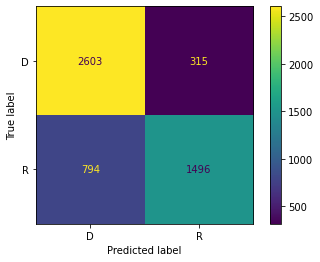

In [194]:
clf_voting = build_model(X_train['bill_summary'], y_train, X_test['bill_summary'], y_test,
                         VotingClassifier(estimators=[
                             ("lr", clf_lr),
                             ("nb", clf_nb),
                             ("svc", clf_svc),
                             ("rf", clf_rf)],
                                          voting='soft'),
                         max_df=0.5,
                         min_df=1,
                         ngram_range=(1,3),
                         strip_accents='unicode',
                         use_idf=True)

# ROC Curves

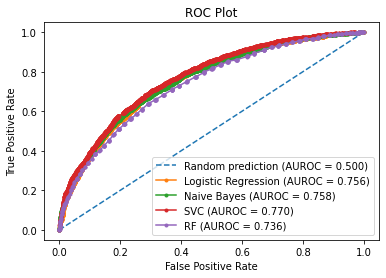

In [16]:
# Create vectorizers
vectorizer_lr = TfidfVectorizer(max_df = 0.5, min_df=1, ngram_range=(1,3), stop_words='english',
                                strip_accents=None, use_idf=True)
vectorizer_nb = TfidfVectorizer(max_df = 0.005, min_df=1, ngram_range=(1,3), stop_words='english',
                                strip_accents='unicode', use_idf=True)
vectorizer_svc = TfidfVectorizer(max_df = 0.5, min_df=5, ngram_range=(1,3), stop_words='english',
                                strip_accents='unicode', use_idf=True)
vectorizer_rf = TfidfVectorizer(max_df = 0.1, min_df=2, ngram_range=(1,2), stop_words='english',
                                strip_accents='unicode', use_idf=True)

# Get vectorized test data
X_test_vec_lr = get_test_vec(X_train['bill_summary'], X_test['bill_summary'], vectorizer_lr)
X_test_vec_nb = get_test_vec(X_train['bill_summary'], X_test['bill_summary'], vectorizer_nb)
X_test_vec_svc = get_test_vec(X_train['bill_summary'], X_test['bill_summary'], vectorizer_svc)
X_test_vec_rf = get_test_vec(X_train['bill_summary'], X_test['bill_summary'], vectorizer_rf)

# Calculate the probabilities
y_probs_lr = cross_val_predict(clf_lr, X_test_vec_lr, y_test, cv=3, method="predict_proba", n_jobs=-1)
y_probs_nb = cross_val_predict(clf_nb, X_test_vec_nb, y_test, cv=3, method="predict_proba", n_jobs=-1)
y_probs_svc = cross_val_predict(clf_svc, X_test_vec_svc, y_test, cv=3, method="predict_proba", n_jobs=-1)
y_probs_rf = cross_val_predict(clf_rf, X_test_vec_rf, y_test, cv=3, method="predict_proba", n_jobs=-1)

# Get the probability of the positive class as the score
y_scores_lr = [i[1] for i in y_probs_lr]
y_scores_nb = [i[1] for i in y_probs_nb]
y_scores_svc = [i[1] for i in y_probs_svc]
y_scores_rf = [i[1] for i in y_probs_rf]

# Remap y values to numeric
y_test_num = y_test.replace({'D':0, 'R':1})

# Get random guess for baseline
r_probs = np.zeros(len(y_test))

# Calculate values to plot ROC curve
fpr_random, tpr_random, _ = roc_curve(y_test_num, r_probs)
fpr_lr, tpr_lr, _ = roc_curve(y_test_num, y_scores_lr)
fpr_nb, tpr_nb, _ = roc_curve(y_test_num, y_scores_nb)
fpr_svc, tpr_svc, _ = roc_curve(y_test_num, y_scores_svc)
fpr_rf, tpr_rf, _ = roc_curve(y_test_num, y_scores_rf)

# Get AUROC scores
r_auc = roc_auc_score(y_test_num, r_probs)
lr_auc = roc_auc_score(y_test_num, y_scores_lr)
nb_auc = roc_auc_score(y_test_num, y_scores_nb)
svc_auc = roc_auc_score(y_test_num, y_scores_svc)
rf_auc = roc_auc_score(y_test_num, y_scores_rf)

# Plot
plt.plot(fpr_random, tpr_random, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(fpr_lr, tpr_lr, marker='.', label='Logistic Regression (AUROC = %0.3f)' % lr_auc)
plt.plot(fpr_nb, tpr_nb, marker='.', label='Naive Bayes (AUROC = %0.3f)' % nb_auc)
plt.plot(fpr_svc, tpr_svc, marker='.', label='SVC (AUROC = %0.3f)' % svc_auc)
plt.plot(fpr_rf, tpr_rf, marker='.', label='RF (AUROC = %0.3f)' % rf_auc)


plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('ROC.png')
plt.show()

# Shifterator

In [97]:
# Filter by sponsor party
rep = df[df['sponsor_party'] == 'R']
dem = df[df['sponsor_party'] == 'D']

# Get word frequencies
dem_corpora_full = word_count_pipeline(dem['bill_summary'])
rep_corpora_full = word_count_pipeline(rep['bill_summary'])
dem_corpora_hf = word_count_pipeline(dem['hf_summary'])
rep_corpora_hf = word_count_pipeline(rep['hf_summary'])

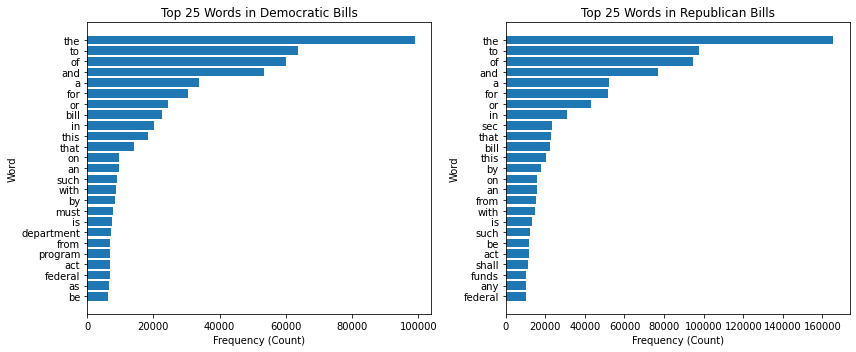

In [98]:
plot_word_counts(dem_corpora_full, rep_corpora_full)

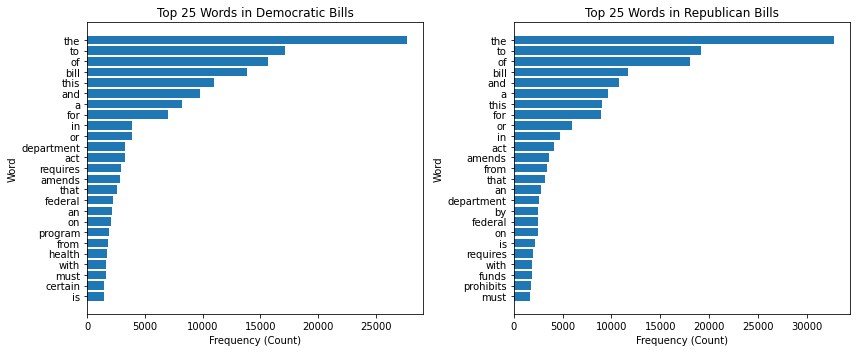

In [99]:
plot_word_counts(dem_corpora_hf, rep_corpora_hf)

In [89]:
# Create stopwords
stop_words = stopwords.words('english')
additional_stopwords = ['bill',
                        'must',
                        'department',
                        'program',
                        'act',
                        'federal',
                        'shall',
                        'requires',
                        'requirements',
                        'services',
                        'may',
                        'certain',
                        'state',
                        'states',
                        'national',
                        'programs',
                        'provide',
                        'amends',
                        'also',
                        'u',
                        'use',
                        'used',
                        'i', 'e']
stop_words.extend(additional_stopwords)

In [122]:
# # Get word frequencies with stop words removed
dem_corpora_full_no_sw = remove_stopwords(dem_corpora_full)
rep_corpora_full_no_sw = remove_stopwords(rep_corpora_full)
dem_corpora_hf_no_sw = remove_stopwords(dem_corpora_hf)
rep_corpora_hf_no_sw = remove_stopwords(rep_corpora_hf)

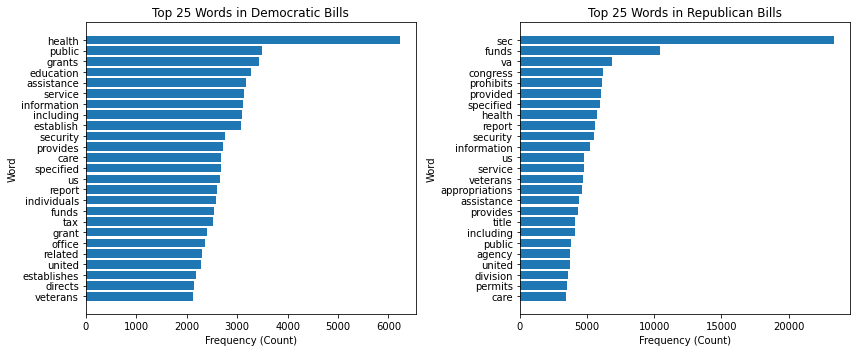

In [124]:
plot_word_counts(dem_corpora_full_no_sw, rep_corpora_full_no_sw)

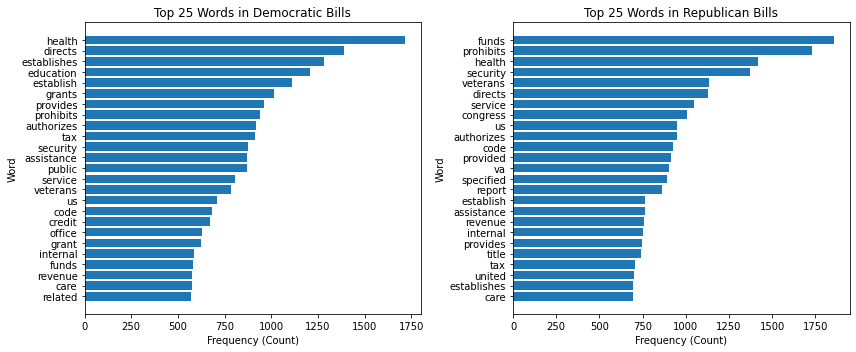

In [125]:
plot_word_counts(dem_corpora_hf_no_sw, rep_corpora_hf_no_sw)

In [127]:
dem2count_full = convert_shifterator(dem_corpora_full_no_sw)
rep2count_full = convert_shifterator(rep_corpora_full_no_sw)
dem2count_hf = convert_shifterator(dem_corpora_hf_no_sw)
rep2count_hf = convert_shifterator(rep_corpora_hf_no_sw)

In [170]:
# os.chdir('/media/data/uvm/2021_fall/CS254/shifterator-master')
# from myshifterator import EntropyShift, ProportionShift

/media/data/uvm/2021_fall/CS254/shifterator-master/myshifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


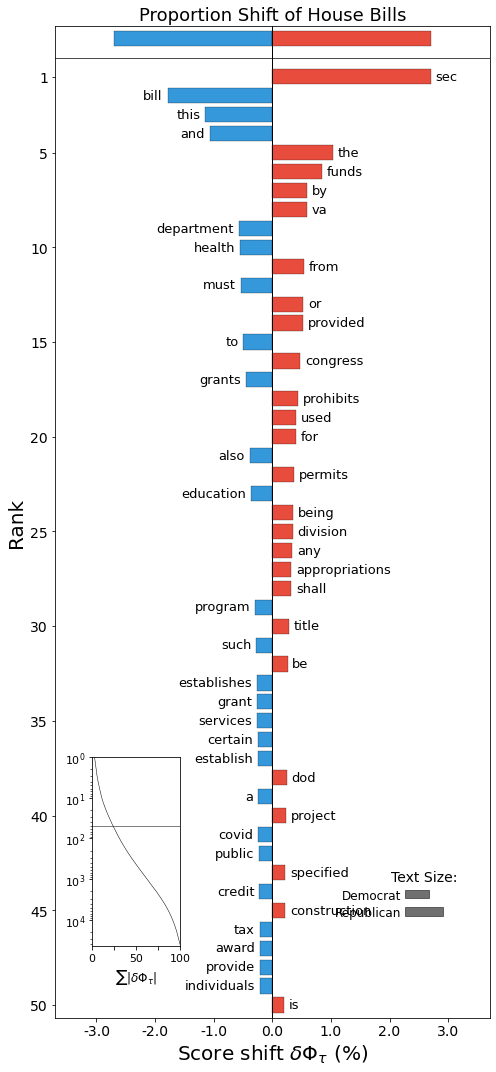

In [189]:
proportion_shift = ProportionShift(type2freq_1=dem2count_full,
                                      type2freq_2=rep2count_full)
proportion_shift.get_shift_graph(title='Proportion Shift of House Bills')
plt.show();

/media/data/uvm/2021_fall/CS254/shifterator-master/myshifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


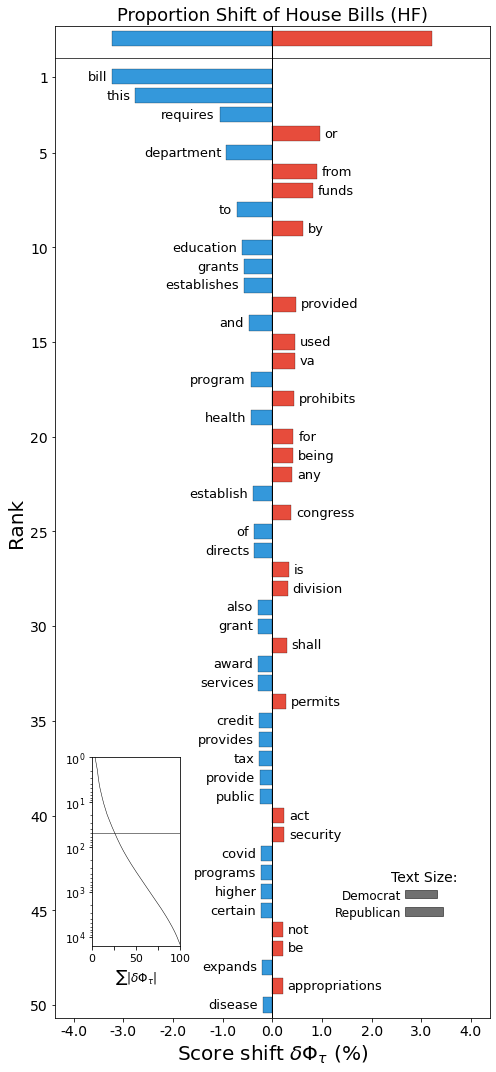

In [191]:
proportion_shift = ProportionShift(type2freq_1=dem2count_hf,
                                      type2freq_2=rep2count_hf)
proportion_shift.get_shift_graph(#system_names=["Democrat", 'Republican'],
                                 title='Proportion Shift of House Bills (HF)')
plt.show();

/media/data/uvm/2021_fall/CS254/shifterator-master/myshifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


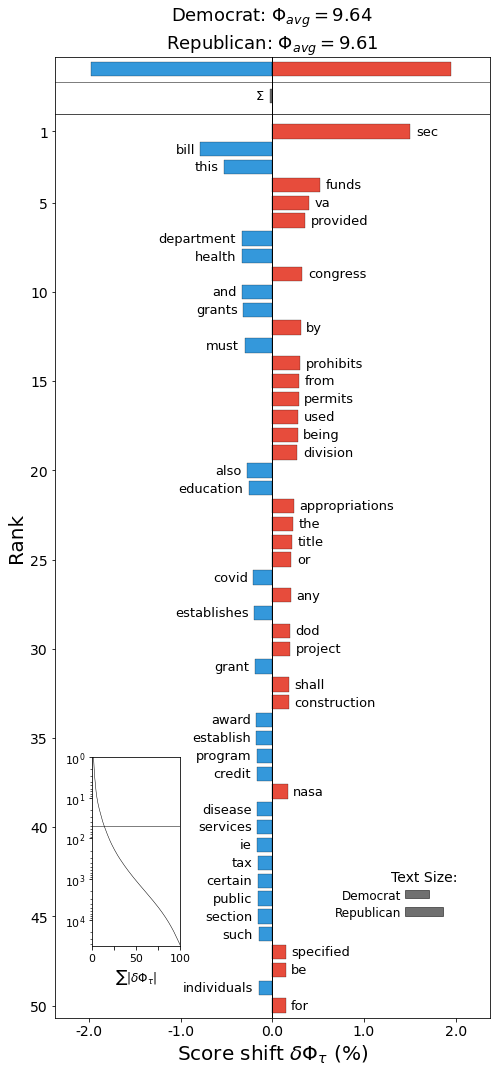

In [185]:
entropy_shift = EntropyShift(type2freq_1=dem2count_full,
                             type2freq_2=rep2count_full,
                             base=2)
entropy_shift.get_shift_graph()
plt.show();

/media/data/uvm/2021_fall/CS254/shifterator-master/myshifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


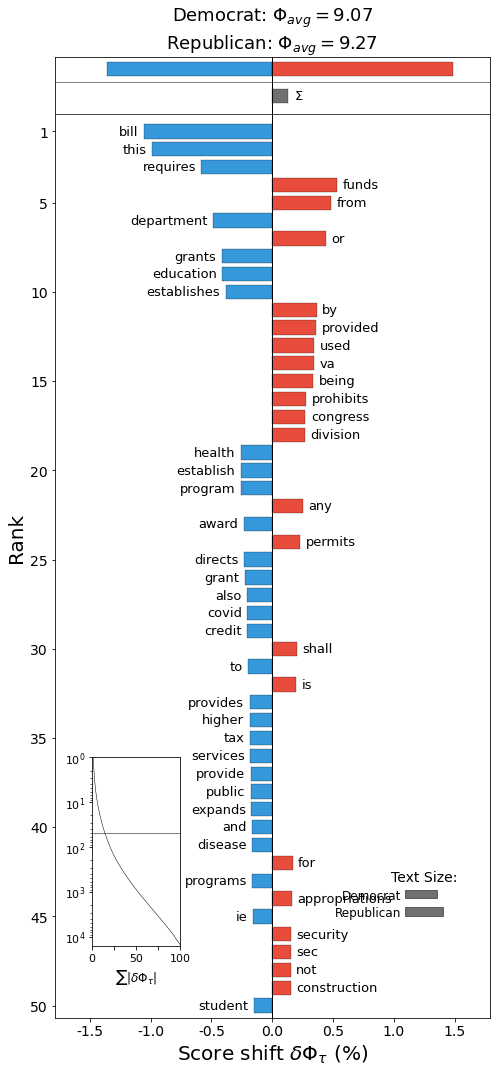

In [192]:
entropy_shift = EntropyShift(type2freq_1=dem2count_hf,
                             type2freq_2=rep2count_hf,
                             base=2)
entropy_shift.get_shift_graph(system_names = ['Democrat', 'Republican'])
plt.show();